In [70]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics import adjusted_rand_score

In [72]:
# Force Plate
df_fp_open = pd.read_csv("../data/processed/ML_datasets/oa_averages_open_fp.csv")
df_fp_closed = pd.read_csv("../data/processed/ML_datasets/oa_averages_closed_fp.csv")

# Zed
df_zed_open = pd.read_csv("../data/processed/ML_datasets/oa_averages_open_zed.csv")
df_zed_closed = pd.read_csv("../data/processed/ML_datasets/oa_averages_closed_zed.csv")

# Front Phone
df_front_open = pd.read_csv("../data/processed/ML_datasets/oa_averages_open_front.csv")
df_front_closed = pd.read_csv("../data/processed/ML_datasets/oa_averages_closed_front.csv")

# Back Phone
df_back_open = pd.read_csv("../data/processed/ML_datasets/oa_averages_open_back.csv")
df_back_closed = pd.read_csv("../data/processed/ML_datasets/oa_averages_closed_back.csv")


## PCA

In [73]:
# Columns to always drop
drop_cols = ["age", "gender", "height", "weight", "foot length", "foot width",
             "participant name", "low stability", "faller"]

# Organize datasets
datasets = {
    "ForcePlate-Open": df_fp_open,
    "ForcePlate-Closed": df_fp_closed,
    "ZED-Open": df_zed_open,
    "ZED-Closed": df_zed_closed,
    "Front-Open": df_front_open,
    "Front-Closed": df_front_closed,
    "Back-Open": df_back_open,
    "Back-Closed": df_back_closed,
}

# Results containers
summary_rows = []
loadings_dict = {}

# Run PCA for each dataset
for name, df in datasets.items():
    # Prepare features
    features = df.drop(columns=[c for c in drop_cols if c in df.columns], errors="ignore")
    feature_names = features.columns
    
    # Standardize
    X_scaled = StandardScaler().fit_transform(features)
    
    # PCA
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)
    explained_var = pca.explained_variance_ratio_
    
    # Collect summary (PC1–PC3)
    summary_rows.append({
        "Dataset": name,
        "PC1 %": explained_var[0]*100,
        "PC2 %": explained_var[1]*100,
        "Cumulative % (2 PCs)": np.sum(explained_var[:2])*100,
        "PC3 %": explained_var[2]*100 if len(explained_var) > 2 else np.nan,
        "Cumulative % (3 PCs)": np.sum(explained_var[:3])*100,
        "PC4 %": explained_var[3]*100 if len(explained_var) > 3 else np.nan,
        "Cumulative % (4 PCs)": np.sum(explained_var[:4])*100
    })
    
    # Collect loadings
    loadings = pd.DataFrame(
        pca.components_.T,
        columns=[f"PC{i}" for i in range(1, len(feature_names)+1)],
        index=feature_names
    )
    loadings_dict[name] = loadings

# Build summary table
summary_df = pd.DataFrame(summary_rows).round(2)
summary_df



,Dataset,PC1 %,PC2 %,Cumulative % (2 PCs),PC3 %,Cumulative % (3 PCs),PC4 %,Cumulative % (4 PCs)
0,ForcePlate-Open,86.82,6.53,93.35,5.49,98.84,0.69,99.52
1,ForcePlate-Closed,94.14,3.27,97.41,1.58,99.00,0.53,99.53
2,ZED-Open,80.78,13.44,94.22,3.92,98.14,1.49,99.63
3,ZED-Closed,85.18,10.06,95.23,3.82,99.05,0.53,99.58
4,Front-Open,90.61,7.53,98.14,1.49,99.63,0.23,99.86
5,Front-Closed,91.86,3.75,95.61,3.24,98.85,0.96,99.81
6,Back-Open,89.18,7.44,96.62,2.53,99.15,0.68,99.83
7,Back-Closed,91.56,4.67,96.23,3.19,99.41,0.43,99.85


In [45]:
# print("\n=== Example Loadings (ForcePlate-Closed, first 3 PCs) ===")
# print(loadings_dict["ForcePlate-Closed"].iloc[:, :3])

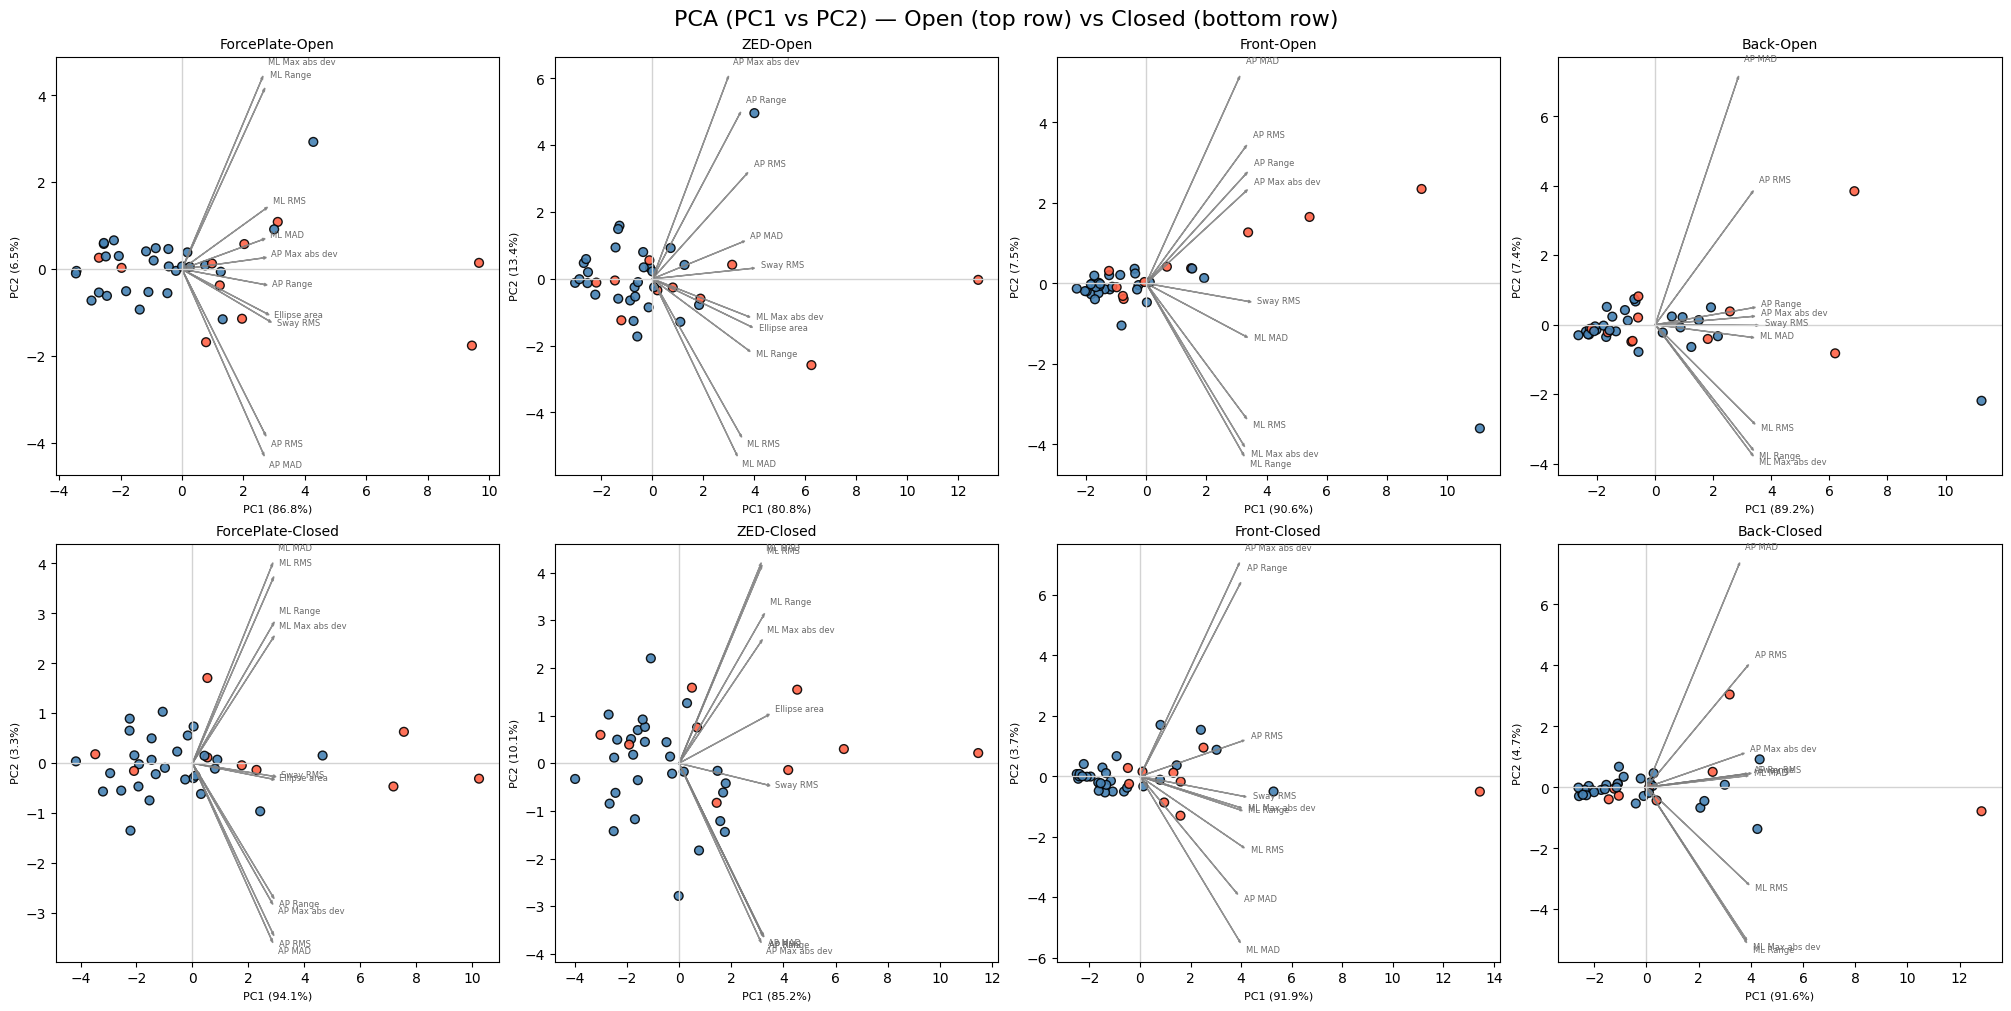

In [74]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10), constrained_layout=True)

layout = [
    ("ForcePlate-Open", "ForcePlate-Closed"),
    ("ZED-Open", "ZED-Closed"),
    ("Front-Open", "Front-Closed"),
    ("Back-Open", "Back-Closed"),
]

drop_cols = ["age", "gender", "height", "weight", "foot length", "foot width",
             "participant name", "low stability", "faller"]

for col_idx, (open_name, closed_name) in enumerate(layout):
    for row_idx, dname in enumerate([open_name, closed_name]):
        ax = axes[row_idx, col_idx]
        df = datasets[dname]

        # features / labels
        y = df["low stability"].values if "low stability" in df.columns else None
        feats = df.drop(columns=[c for c in drop_cols if c in df.columns], errors="ignore")
        feat_names = feats.columns.tolist()
        if len(feat_names) == 0:
            ax.set_title(f"{dname} (no features)")
            ax.axis("off")
            continue

        # scale + PCA(2)
        Xs = StandardScaler().fit_transform(feats.values)
        pca2 = PCA(n_components=2, random_state=42)
        scores = pca2.fit_transform(Xs)
        loadings = pca2.components_.T
        expl = pca2.explained_variance_ratio_ * 100.0

        # scatter
        if y is not None:
            colors = np.where(y == 1, "tomato", "steelblue")
        else:
            colors = "C0"
        ax.scatter(scores[:, 0], scores[:, 1], c=colors, s=40,
                   edgecolor="k", alpha=0.9)

        # arrows
        score_max = np.max(np.abs(scores[:, :2]))
        arrow_scale = 0.9 * score_max if np.isfinite(score_max) and score_max > 0 else 1.0
        for i, fname in enumerate(feat_names):
            x, yv = loadings[i, 0]*arrow_scale, loadings[i, 1]*arrow_scale
            ax.arrow(0, 0, x, yv, width=0.0015, head_width=0.06,
                     length_includes_head=True, color="gray", alpha=0.85)
            ax.text(x*1.06, yv*1.06, fname, fontsize=6, color="dimgray")

        # cosmetics
        ax.axhline(0, color="lightgray", lw=1)
        ax.axvline(0, color="lightgray", lw=1)
        ax.set_xlabel(f"PC1 ({expl[0]:.1f}%)", fontsize=8)
        ax.set_ylabel(f"PC2 ({expl[1]:.1f}%)", fontsize=8)
        ax.set_title(dname, fontsize=10)

plt.suptitle("PCA (PC1 vs PC2) — Open (top row) vs Closed (bottom row)", fontsize=16)
plt.show()

## Hierarchical Clustering

Global participant → number mapping:
1           ann
2         ann-m
3          anna
4          arie
5       avraham
6     bat-sheva
7         batya
8         benny
9         david
10         dida
11        ester
12       fabian
13        gidon
14         gita
15        ilana
16         inez
17        mazal
18         meir
19      michael
20       miryam
21     mordehai
22        moshe
23      naftali
24        naomi
25        rahel
26         raya
27       ronald
28       shalom
29     shalom_l
30         tami
31         tina
32         tova
33          uri
34       yaacov
35     yaacov_e
36        yaffa
37       yossef
38        yossi
dtype: object


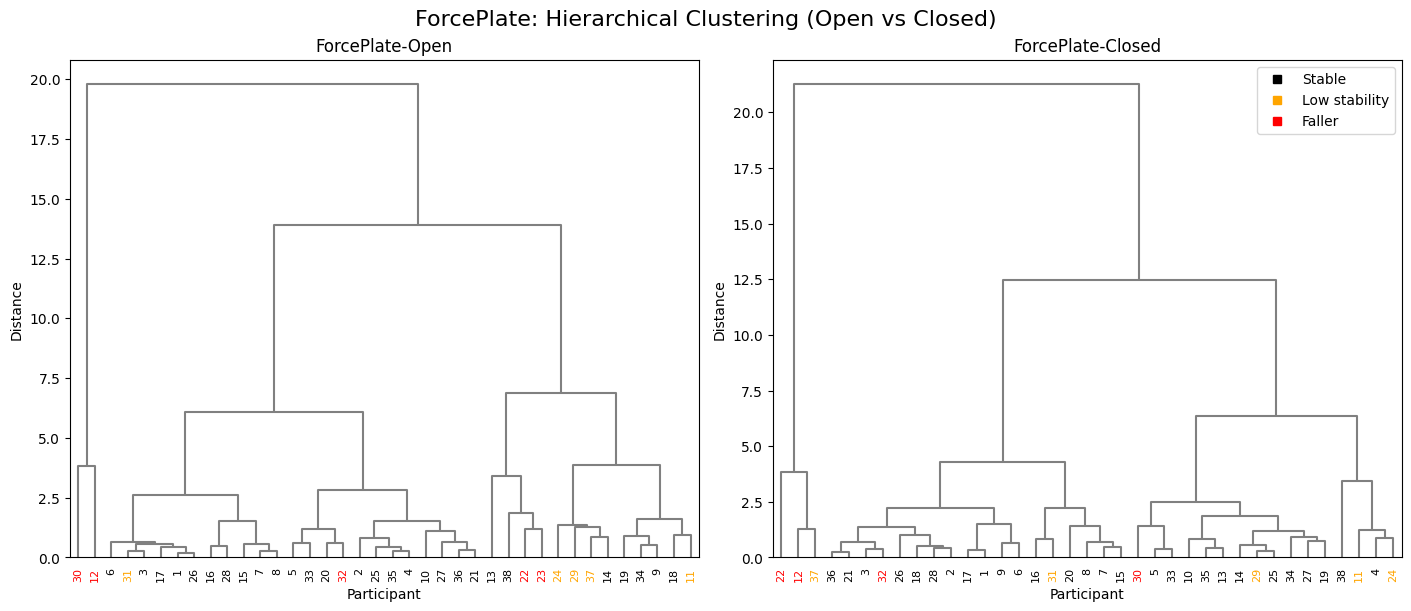

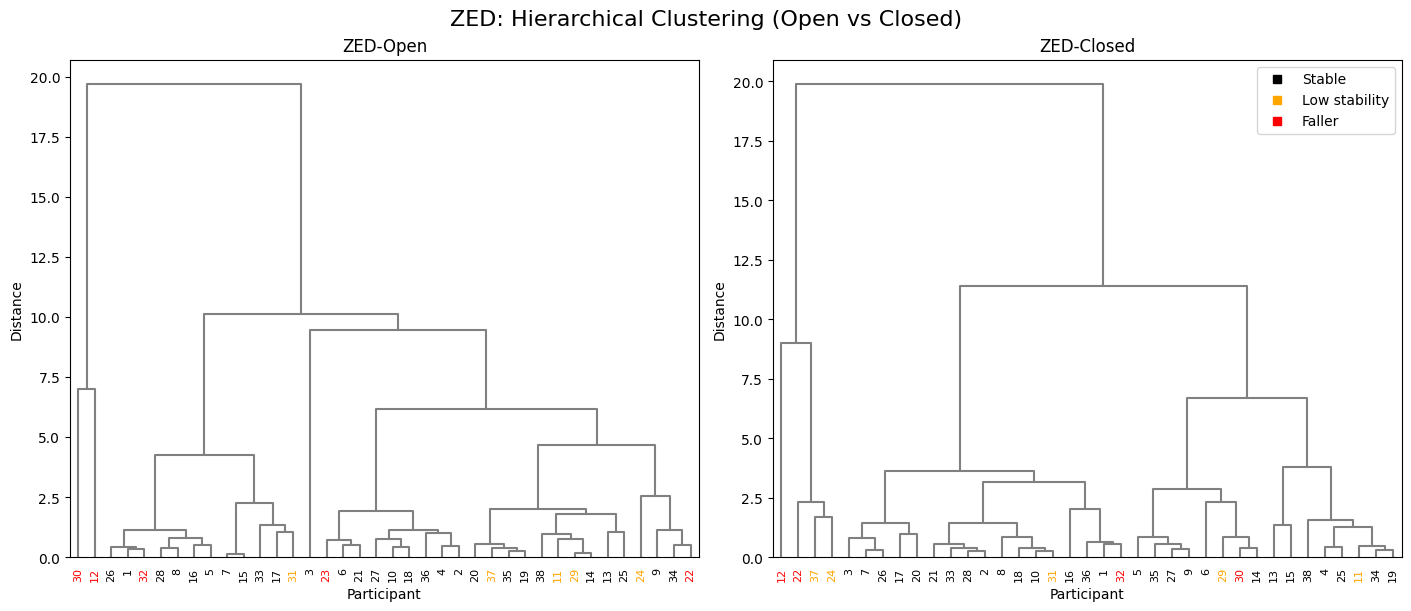

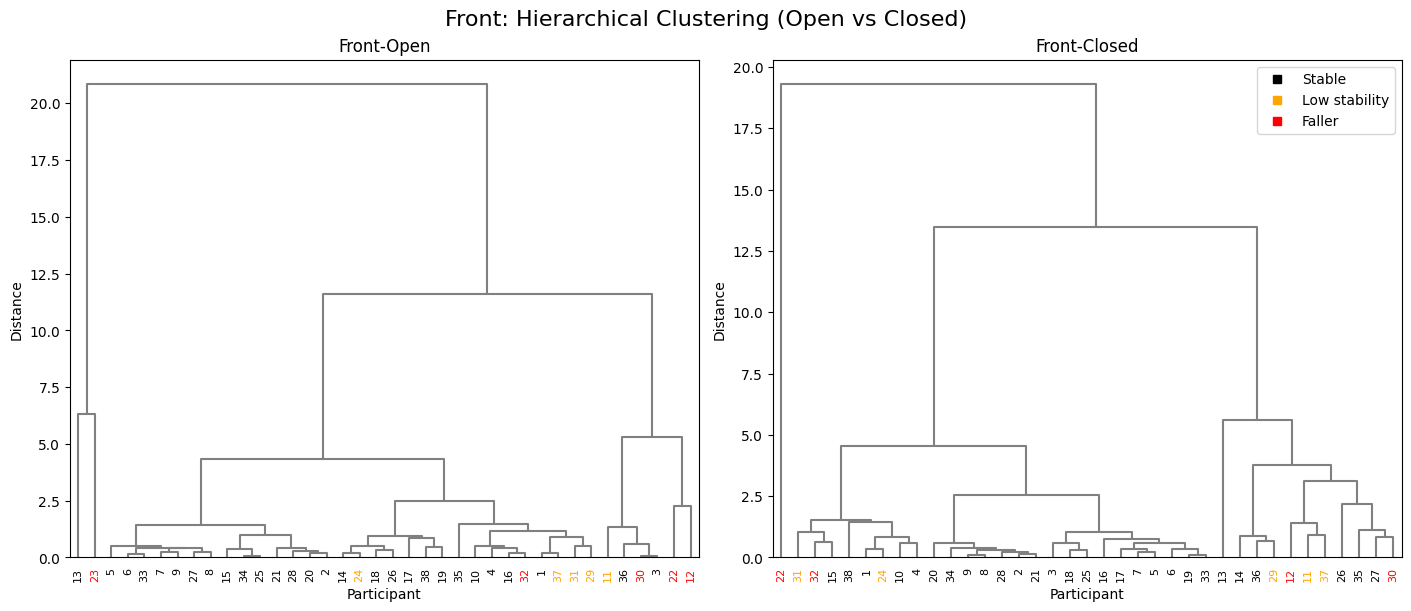

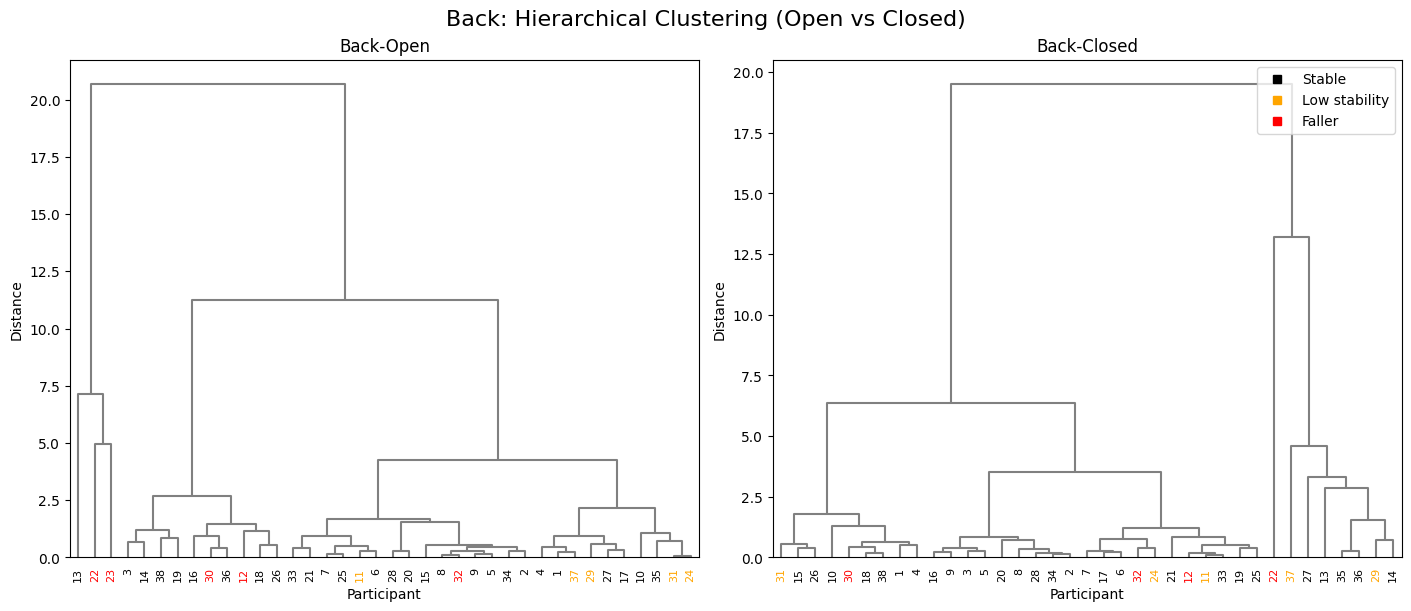

In [77]:
# ---- config ----
use_pca = True
n_components = 3
method = "ward"
metric = "euclidean"

drop_cols = ["age","gender","height","weight","foot length","foot width"]

devices = {
    "ForcePlate": ("ForcePlate-Open", "ForcePlate-Closed"),
    "ZED": ("ZED-Open", "ZED-Closed"),
    "Front": ("Front-Open", "Front-Closed"),
    "Back": ("Back-Open", "Back-Closed"),
}

def group_color(y, f, idx):
    if f[idx] == 1:
        return "red"
    elif y[idx] == 1:
        return "orange"
    else:
        return "black"

# ---------- 0) Build a GLOBAL participant -> number mapping ----------
all_names = []
for df in datasets.values():
    if "participant name" in df.columns:
        all_names.extend(df["participant name"].astype(str).tolist())

# use alphabetical order for determinism (or keep set order if you prefer)
pid_map = {name: i+1 for i, name in enumerate(sorted(set(all_names)))}

# (optional) print the mapping once
print("Global participant → number mapping:")
print(pd.Series({v:k for k,v in pid_map.items()}).sort_index())

# ---------- 1) Plot per device: Open (left) vs Closed (right) ----------
for dev, (open_name, closed_name) in devices.items():
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)

    for ax, dname in zip(axes, [open_name, closed_name]):
        df = datasets[dname].copy()
        df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors="ignore")

        participants = df["participant name"].astype(str).values
        y = df["low stability"].astype(int).values if "low stability" in df.columns else np.zeros(len(participants), dtype=int)
        f = df["faller"].astype(int).values if "faller" in df.columns else np.zeros(len(participants), dtype=int)

        X = df.drop(columns=[c for c in ["participant name","low stability","faller"] if c in df.columns], errors="ignore").values
        Xs = StandardScaler().fit_transform(X)
        if use_pca:
            Xs = PCA(n_components=n_components, random_state=42).fit_transform(Xs)

        # Use the SAME participant numbers everywhere
        numeric_labels = [str(pid_map[name]) for name in participants]

        D = dendrogram(
            linkage(Xs, method=method, metric=metric),
            labels=numeric_labels,           # fixed numbers per participant
            leaf_rotation=90,
            leaf_font_size=8,
            link_color_func=lambda k: "grey",
            color_threshold=0,
            ax=ax
        )

        # Color the numbers according to each leaf's original participant index
        tick_labels = ax.get_xmajorticklabels()
        for j, lbl in enumerate(tick_labels):
            orig_idx = D["leaves"][j]                  # index into participants/y/f of THIS dataset
            lbl.set_color(group_color(y, f, orig_idx))

        ax.set_title(dname)
        ax.set_xlabel("Participant")
        ax.set_ylabel("Distance")

    handles = [
        Line2D([0],[0], color="black",  marker="s", lw=0, label="Stable"),
        Line2D([0],[0], color="orange", marker="s", lw=0, label="Low stability"),
        Line2D([0],[0], color="red",    marker="s", lw=0, label="Faller"),
    ]
    axes[1].legend(handles=handles, loc="upper right", frameon=True)
    fig.suptitle(f"{dev}: Hierarchical Clustering (Open vs Closed)", fontsize=16)
    plt.show()

In [76]:
# --- Run clustering with and without PCA and compare ---
for dev, (open_name, closed_name) in devices.items():
    for dname in [open_name, closed_name]:
        df = datasets[dname].copy()
        df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors="ignore")

        participants = df["participant name"].astype(str).values
        X = df.drop(columns=[c for c in ["participant name","low stability","faller"] if c in df.columns], errors="ignore").values
        Xs = StandardScaler().fit_transform(X)

        # --- without PCA ---
        Z_raw = linkage(Xs, method=method, metric=metric)
        labels_raw = fcluster(Z_raw, t=2, criterion="maxclust")

        # --- with PCA ---
        X_pca = PCA(n_components=3, random_state=42).fit_transform(Xs)
        Z_pca = linkage(X_pca, method=method, metric=metric)
        labels_pca = fcluster(Z_pca, t=2, criterion="maxclust")

        # --- compare ---
        ari = adjusted_rand_score(labels_raw, labels_pca)
        print(f"{dname}: ARI between raw vs PCA clustering = {ari:.3f}")


ForcePlate-Open: ARI between raw vs PCA clustering = 1.000
ForcePlate-Closed: ARI between raw vs PCA clustering = 1.000
ZED-Open: ARI between raw vs PCA clustering = 0.635
ZED-Closed: ARI between raw vs PCA clustering = 1.000
Front-Open: ARI between raw vs PCA clustering = 0.600
Front-Closed: ARI between raw vs PCA clustering = 1.000
Back-Open: ARI between raw vs PCA clustering = 1.000
Back-Closed: ARI between raw vs PCA clustering = 1.000
